In [1]:
#imports

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
import onnx
from onnx import version_converter
import torch

ort.get_device()

'GPU'

In [2]:
# config
MODELS_PATH = Path("../saved_models/cvpr_games_oct_30_onnx/") # relative to ipynb
IMAGES_PATH = Path("../data/imagenette2-320") # relative to ipynb

BASELINE_PATH = Path("baseline.onnx") # converted to higher opset

# pick a model to measure
some_model = MODELS_PATH/"Sat_Oct_28_18_44_34_2023_starry_night_1_1E05_1E10_1E03.onnx"
torch_model_path = Path("../saved_models/cvpr_games_oct_30/Sat_Oct_28_18_44_34_2023_starry_night_1_1E05_1E10_1E03.pth")

# basic optimisations
OPTIMISED_PATH = Path("optimised.onnx")
FP16_PATH = Path("baseline_fp16.onnx")
IDENTITYNET_PATH = Path("identity.onnx")

# quantization (very slow)
QUANTIZED_PATH = Path("quantized_int8.onnx")

# distilations
RES2_PATH = Path("transformerNetFusion_res2.onnx")
RES1_PATH = Path("transformerNetFusion_res1.onnx")
SEPARATED_PATH = Path("transformerNetFusion_separated.onnx")
SEPARATED_2xSCALED_PATH = Path("transformerNetFusion_separated_2xscaled.onnx")
SEPARATED_4xSCALED_PATH = Path("transformerNetFusion_separated_4xscaled.onnx")

input_shape = (1,3,640,640) # checked beforehand

if not any(MODELS_PATH.glob("*.onnx")):
    raise RuntimeError("Models not found, you didn't clone the GBGST repo or sometthing is very wrong")


PROVIDERS = ["CUDAExecutionProvider"] # dont use tensorrt, or don't try to measure on CPU

In [3]:
# inference
from tqdm import tqdm
import time

def measure_model(model: Path, dtype: type, iters=100) -> float:
    rng = np.random.default_rng()
    ort_sess = ort.InferenceSession(model, providers=PROVIDERS) # not using tensorrt

    start_time = time.time()
    for i in tqdm(range(iters)):
        x = rng.random(input_shape).astype(dtype)
        ort_sess.run(None, {'input': x})
    return time.time()-start_time

In [4]:
# pick a model to measure
some_model = list(MODELS_PATH.glob("*.onnx"))[0]

onnx_model = onnx.load(some_model)
onnx.checker.check_model(onnx_model)
print(onnx_model.opset_import[0].version)



# convert model to newest opset for quantisation!
converted = version_converter.convert_version(onnx_model, 17)
onnx.save(converted,BASELINE_PATH)


9


showing ../data/imagenette2-320/val/n01440764/ILSVRC2012_val_00009111.JPEG


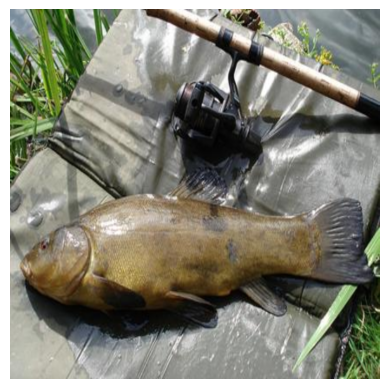

Output shape: (1, 3, 640, 640)


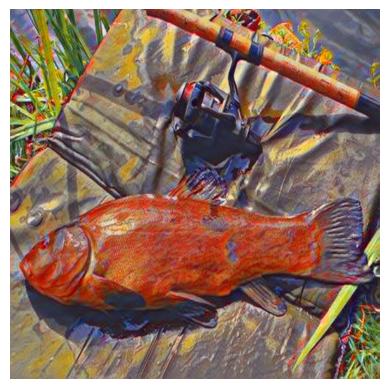

showing ../data/imagenette2-320/val/n01440764/ILSVRC2012_val_00009111.JPEG


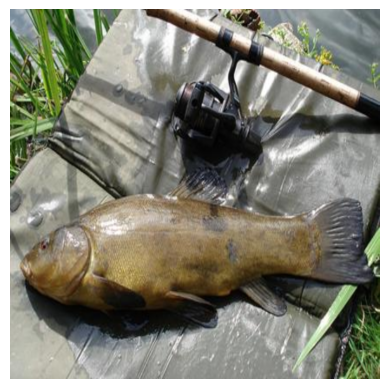

Output shape: (1, 3, 640, 640)


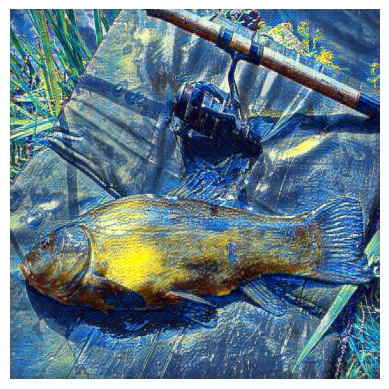

In [67]:
# pass example image through the network
# load image from data folder
from transformer_net_fusion import TransformerNetFusion


def stylize_and_display_image(image_path: Path, model_path: Path, dtype=np.float32):
    print("showing",image_path)
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 640))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    input_tensor = image.astype(dtype)
    input_tensor = np.transpose(input_tensor, (2,0,1)) # HWC to CHW
    input_tensor = np.expand_dims(input_tensor, axis=0) # add batch dim
    input_name = "input"
    ort_sess = ort.InferenceSession(model_path, providers=PROVIDERS)
    outputs = ort_sess.run(None, {input_name: input_tensor})
    output_tensor = outputs[0]
    print("Output shape:", output_tensor.shape)
    # display output as image
    output_image = np.squeeze(output_tensor, axis=0) # remove batch dim
    output_image = np.transpose(output_image, (1,2,0)) # CHW to
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

def stylize_and_display_image_pth(image_path: Path, pth_path: Path):
    print("showing",image_path)
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 640))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    input_tensor = image.astype(np.float32)
    input_tensor = np.transpose(input_tensor, (2,0,1)) # HWC to CHW
    input_tensor = np.expand_dims(input_tensor, axis=0) # add batch dim
    input_name = "input"
    
    model = TransformerNetFusion().to('cuda')
    model.load_state_dict(torch.load(pth_path))
    model.eval()
    with torch.no_grad():
        input_tensor_torch = torch.from_numpy(input_tensor).to('cuda')
        output_tensor_torch = model(input_tensor_torch)
        output_tensor = output_tensor_torch.cpu().numpy()
    print("Output shape:", output_tensor.shape)
    # display output as image
    output_image = np.squeeze(output_tensor, axis=0) # remove batch dim
    output_image = np.transpose(output_image, (1,2,0)) # CHW to
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

stylize_and_display_image(IMAGES_PATH / "val/n01440764/ILSVRC2012_val_00009111.JPEG", BASELINE_PATH)
stylize_and_display_image_pth(IMAGES_PATH / "val/n01440764/ILSVRC2012_val_00009111.JPEG", torch_model_path) # they look different??...

In [6]:
# create identity model for benchmark
import torch.nn as nn

class IdentityNet(nn.Module):
	def __init__(self):
		super().__init__()

		self.conv = nn.Conv2d(3,3,1)
		# initialize convolution as identity
		with torch.no_grad():
			self.conv.weight.zero_()
			for i in range(3):
				self.conv.weight[i, i, 0, 0] = 1.0
			self.conv.bias.zero_()
	
	def forward(self, x):
		x = self.conv(x)
		return x

# Example usage:
model = IdentityNet()
sample_input = torch.randn(input_shape)
output = model(sample_input)
print(output.shape)

# save to onnx
torch.onnx.export(
	model, 
	(torch.zeros(input_shape),), 
	IDENTITYNET_PATH, 
	input_names=["input"], 
	output_names=["output"], 
)

torch.Size([1, 3, 640, 640])


In [7]:
# optymalizacja
import onnxoptimizer
print(onnxoptimizer.get_fuse_and_elimination_passes())

passes = onnxoptimizer.get_fuse_and_elimination_passes()
optimized_model = onnxoptimizer.optimize(onnx_model, passes)
onnx.save(optimized_model, OPTIMISED_PATH)

['nop', 'eliminate_nop_cast', 'eliminate_nop_dropout', 'eliminate_nop_flatten', 'extract_constant_to_initializer', 'eliminate_consecutive_idempotent_ops', 'eliminate_if_with_const_cond', 'eliminate_nop_monotone_argmax', 'eliminate_nop_pad', 'eliminate_nop_concat', 'eliminate_nop_split', 'eliminate_nop_expand', 'eliminate_shape_gather', 'eliminate_slice_after_shape', 'eliminate_nop_transpose', 'fuse_add_bias_into_conv', 'fuse_bn_into_conv', 'fuse_consecutive_concats', 'fuse_consecutive_log_softmax', 'fuse_consecutive_reduce_unsqueeze', 'fuse_consecutive_squeezes', 'fuse_consecutive_transposes', 'fuse_matmul_add_bias_into_gemm', 'fuse_pad_into_conv', 'fuse_pad_into_pool', 'fuse_transpose_into_gemm', 'fuse_concat_into_reshape', 'eliminate_nop_reshape', 'eliminate_nop_with_unit', 'eliminate_common_subexpression', 'fuse_qkv', 'fuse_consecutive_unsqueezes', 'eliminate_deadend', 'eliminate_identity', 'eliminate_shape_op', 'fuse_consecutive_slices', 'eliminate_unused_initializer', 'eliminate_d

## Kwantyzacja

In [8]:
from onnxruntime.quantization import quantize_static, QuantType, CalibrationDataReader

In [9]:
# preprocess target model

from onnxruntime.quantization import preprocess

preprocess.quant_pre_process(converted, output_model_path="preprocessed.onnx")

In [10]:
# from https://medium.com/@nashrakhan1008/model-quantization-8f10c537e0eb

from concurrent.futures import ThreadPoolExecutor
import os
import cv2


class MyCalibrationDataReader(CalibrationDataReader):
    def __init__(self, image_folder, batch_size=1, input_size=(640, 640)):
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.input_size = input_size
        self.image_files = os.listdir(str(image_folder))
        self.index = 0

    def preprocess_image(self, img_path):
        """Preprocess image by reading and resizing."""
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.input_size)  # resize to input_size
        img = img.astype(np.float32)  # Ensure float32 for ONNX
        return img

    def get_next(self) -> dict:
        """Generate the next batch of input data for inference."""
        if self.index >= len(self.image_files):
            return None  # End of data

        # Create list of image paths for batch processing
        # Create list of image paths for batch processing
        batch_paths = [str(self.image_folder / self.image_files[i]) for i in range(self.index, self.index + self.batch_size)]
        
        # Parallelize image preprocessing
        with ThreadPoolExecutor() as executor:
            batch_images = list(executor.map(self.preprocess_image, batch_paths))
        # Stack and transpose images to match model input shape (batch_size, channels, height, width)
        batch_images = np.stack(batch_images, axis=0)
        batch_images = np.transpose(batch_images, (0, 3, 1, 2))

        # Increment index for next batch
        self.index += self.batch_size
        return {"input": batch_images}

    def __len__(self):
        """Calculate the total number of batches."""
        return len(self.image_files) // self.batch_size

In [11]:
# kwantyzacja
calibration = MyCalibrationDataReader(IMAGES_PATH, 1)

# Takes about 1 minut, uncomment to run
#quantize_static("preprocessed.onnx", 
#                "quantized_int8.onnx",
#                calibration,
#                )

## Inne podejście - konwersja na fp16

In [12]:
from onnxconverter_common import float16

fp16 = float16.convert_float_to_float16(onnx_model)

onnx.save(fp16, FP16_PATH)

measure_model(FP16_PATH,np.float16)

100%|██████████| 100/100 [00:02<00:00, 45.59it/s]


2.1993846893310547

## Destylacja modelu

Domyślnie model ma architekture autokodera z trzema warstwami splotowymi zmniejszającymi obraz, sześcioma do rozszerzenia pojemności modelu, oraz trzema powracającymi do oryginalnego rozmiaru.

Możliwe podejścia:
1. Zmniejszyć liczbę bloków w bottlenecku - modele `4res`, `3res`
2. Zmniejszyć długość kanałów - modele 
2. Zamienić splot na depth-wise separable convolution - ograniczenie liczby parametrów
    * Zamiast splotu po całych aktywacjach, robi się splot na pojedyńczych kanałach, a potem point-wisee splot z jądrem 1x1 aby otrzymać wynik


In [13]:
from transformerNetFusion_res1 import TransformerNetFusion_res1
from transformerNetFusion_res2 import TransformerNetFusion_res2
from transformerNetFusion_separated import TransformerNetFusion_separated
from transformerNetFusion_separated_scaled import TransformerNetFusion_separated_scaled


for model, name, path in [
    (TransformerNetFusion_res1(), "4res", RES1_PATH),
    (TransformerNetFusion_res2(), "3res", RES2_PATH),
    (TransformerNetFusion_separated(), "separated", SEPARATED_PATH),
    (TransformerNetFusion_separated_scaled(alpha=0.75), "separated_scaled", SEPARATED_2xSCALED_PATH),
    (TransformerNetFusion_separated_scaled(alpha=0.5), "separated_scaled", SEPARATED_4xSCALED_PATH),
]:
    sample_input = torch.randn(input_shape)
    torch.onnx.export(
        model, 
        (sample_input,), 
        path, 
        input_names=["input"], 
        output_names=["output"],
        opset_version=9,
        do_constant_folding=True
    )

# run onnxoptimiser on distilled models, because pytorch exports some trash
for path in [RES1_PATH, RES2_PATH, SEPARATED_PATH]:
    onnx_model = onnx.load(path)
    optimized_model = onnxoptimizer.optimize(onnx_model)
    onnx.save(optimized_model, path)

# export as fp16
for path in [RES1_PATH, RES2_PATH, SEPARATED_PATH, SEPARATED_2xSCALED_PATH, SEPARATED_4xSCALED_PATH]:
    onnx_model = onnx.load(path)
    fp16 = float16.convert_float_to_float16(onnx_model)
    onnx.save(fp16, path.with_stem(path.stem + "_fp16"))


/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:1460: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(
/home/tomek/.venv/lib/python3.12/site-packages/torch/onnx/symbolic_helper.py:798: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(
/home/tomek/.venv/lib/python3.12/site-packages/onnxconverter_common/float16.py:70: UserWarning: the float32 number -1.4048949559253288e-08 will be truncated to 

## Porównanie modeli

In [14]:
special_models = [IDENTITYNET_PATH, OPTIMISED_PATH, QUANTIZED_PATH] # models without fp16 versions
models = (BASELINE_PATH, RES2_PATH, RES1_PATH, SEPARATED_PATH, SEPARATED_2xSCALED_PATH, SEPARATED_4xSCALED_PATH)

times = {}

for path in special_models:
    elapsed = measure_model(path, np.float32)
    print(f"{path.name}, Elapsed {elapsed:.3f}s")
    times[path.name] = elapsed

for path in models:
    elapsed = measure_model(path, np.float32)
    print(f"{path.name}, Elapsed {elapsed:.3f}s")
    times[path.name] = elapsed

for path in models:
    fp16_path = path.with_stem(path.stem + "_fp16")
    elapsed = measure_model(fp16_path, np.float16)
    print(f"{fp16_path.name}, Elapsed {elapsed:.3f}s")
    times[fp16_path.name] = elapsed

100%|██████████| 100/100 [00:00<00:00, 118.47it/s]


identity.onnx, Elapsed 0.847s


100%|██████████| 100/100 [00:03<00:00, 29.74it/s]
2026-01-12 03:29:51.852532758 [W:onnxruntime:, transformer_memcpy.cc:111 ApplyImpl] 23 Memcpy nodes are added to the graph torch-jit-export for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2026-01-12 03:29:51.853483348 [W:onnxruntime:, session_state.cc:1316 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2026-01-12 03:29:51.853490276 [W:onnxruntime:, session_state.cc:1318 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


optimised.onnx, Elapsed 3.365s


100%|██████████| 100/100 [00:04<00:00, 24.62it/s]


quantized_int8.onnx, Elapsed 4.064s


100%|██████████| 100/100 [00:03<00:00, 29.88it/s]


baseline.onnx, Elapsed 3.348s


100%|██████████| 100/100 [00:03<00:00, 32.23it/s]


transformerNetFusion_res2.onnx, Elapsed 3.105s


100%|██████████| 100/100 [00:02<00:00, 34.10it/s]


transformerNetFusion_res1.onnx, Elapsed 2.934s


100%|██████████| 100/100 [00:02<00:00, 44.25it/s]


transformerNetFusion_separated.onnx, Elapsed 2.263s


100%|██████████| 100/100 [00:01<00:00, 54.16it/s]


transformerNetFusion_separated_2xscaled.onnx, Elapsed 1.848s


100%|██████████| 100/100 [00:01<00:00, 73.24it/s]


transformerNetFusion_separated_4xscaled.onnx, Elapsed 1.367s


100%|██████████| 100/100 [00:02<00:00, 46.32it/s]


baseline_fp16.onnx, Elapsed 2.160s


100%|██████████| 100/100 [00:02<00:00, 47.60it/s]


transformerNetFusion_res2_fp16.onnx, Elapsed 2.102s


100%|██████████| 100/100 [00:01<00:00, 50.26it/s]


transformerNetFusion_res1_fp16.onnx, Elapsed 1.991s


100%|██████████| 100/100 [00:02<00:00, 48.11it/s]


transformerNetFusion_separated_fp16.onnx, Elapsed 2.081s


100%|██████████| 100/100 [00:01<00:00, 57.32it/s]


transformerNetFusion_separated_2xscaled_fp16.onnx, Elapsed 1.746s


100%|██████████| 100/100 [00:01<00:00, 75.67it/s]

transformerNetFusion_separated_4xscaled_fp16.onnx, Elapsed 1.325s


In [15]:
sorted_times = dict(sorted(times.items(), key=lambda item: item[1]))
sorted_times

{'identity.onnx': 0.8469679355621338,
 'transformerNetFusion_separated_4xscaled_fp16.onnx': 1.3247897624969482,
 'transformerNetFusion_separated_4xscaled.onnx': 1.366950511932373,
 'transformerNetFusion_separated_2xscaled_fp16.onnx': 1.746382713317871,
 'transformerNetFusion_separated_2xscaled.onnx': 1.847823143005371,
 'transformerNetFusion_res1_fp16.onnx': 1.9914758205413818,
 'transformerNetFusion_separated_fp16.onnx': 2.080524206161499,
 'transformerNetFusion_res2_fp16.onnx': 2.1023428440093994,
 'baseline_fp16.onnx': 2.1599905490875244,
 'transformerNetFusion_separated.onnx': 2.2626187801361084,
 'transformerNetFusion_res1.onnx': 2.93359112739563,
 'transformerNetFusion_res2.onnx': 3.105051040649414,
 'baseline.onnx': 3.348043203353882,
 'optimised.onnx': 3.365190267562866,
 'quantized_int8.onnx': 4.063508749008179}

# Trening
Skoro już mamy modele i wiemy ile czasu chodzą, to je trenujemy

In [14]:
# loader with random real images to train on something
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_torchvision_loader(batch_size=4, items=10):
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
    ])
    
    dataset = datasets.ImageFolder(
        root='../data', 
        transform=transform
    )
    subset = torch.utils.data.Subset(dataset, list(range(items)))

    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    return loader

In [57]:
import torch.optim as optim
from transformer_net_fusion import TransformerNetFusion # teacher

def train_distillation(teacher_model_path, student_output_path, student_model, dataloader, num_epochs=10):
    torch.cuda.empty_cache()
    student_model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # load teacher model from pth
    teacher_model = TransformerNetFusion().to(device)
    teacher_model.load_state_dict(torch.load(teacher_model_path))
    teacher_model.eval()
    student_model.to(device)

    optimizer = optim.Adam(student_model.parameters(), lr=1e-3)

    distillation_loss_fn = nn.MSELoss()

    #dummy_input = torch.randn(1, 3, 640, 640).to(device)
    print("train start")

    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(num_epochs):
        for batch in tqdm(dataloader):
            batch = batch[0].to(device)  # get images from (images, labels) tuple
            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                with torch.no_grad():
                    teacher_output = teacher_model(batch)

                student_output = student_model(batch)

                loss = distillation_loss_fn(student_output, teacher_output)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")
        # export trained student model every epoch, because why not
        print("exporting to",student_output_path)
        torch.cuda.empty_cache()
        sample_input = torch.randn(input_shape).to(device)
        torch.onnx.export(
            student_model, 
            (sample_input,), 
            student_output_path.with_stem(student_output_path.stem + "_distilled"), 
            input_names=["input"], 
            output_names=["output"],
            opset_version=9,
            do_constant_folding=True
        )

In [53]:
# this is slower and limited only to output comparison, but possible
def train_distillation_onnx(student_model, loader, num_epochs=10):
    # 1. Load the ONNX Teacher
    # Use 'CUDAExecutionProvider' if you have onnxruntime-gpu installed
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']
    teacher_session = ort.InferenceSession(BASELINE_PATH, providers=providers)
    
    # Get input names for the ONNX model
    input_name_x = teacher_session.get_inputs()[0].name

    # 2. Initialize PyTorch Student
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student_model = TransformerNetFusion_separated().to(device)
    student_model.train()

    optimizer = optim.Adam(student_model.parameters(), lr=1e-3)
    distillation_loss_fn = nn.MSELoss()

    # Dummy Data

    # 3. Training Loop
    for epoch in range(num_epochs):
        for batch in tqdm(loader):
            img = batch[0]  # get images from (images, labels) tuple
            optimizer.zero_grad()

            # --- Teacher Inference (ONNX) ---
            # ONNX requires numpy arrays, not torch tensors
            x_numpy = img.cpu().numpy()
            
            # Run inference
            onnx_outputs = teacher_session.run(None, {
                input_name_x: x_numpy,
            })
            
            # Convert teacher output back to torch and move to device
            teacher_output = torch.from_numpy(onnx_outputs[0]).to(device)

            # --- Student Inference (PyTorch) ---
            student_output = student_model(img.to(device))

            # 4. Loss and Backprop
            loss = distillation_loss_fn(student_output, teacher_output)
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# loader = get_torchvision_loader(batch_size=1, items=100)
# train_distillation_onnx(
#     student_model=TransformerNetFusion(),
#     loader=loader,
#     num_epochs=5
# )

In [59]:
from transformerNetFusion_separated_scaled import TransformerNetFusion_separated_scaled

torch.cuda.empty_cache()
loader = get_torchvision_loader(batch_size=3, items=1000)

train_distillation(torch_model_path, Path("baseline_distilled.onnx"), TransformerNetFusion(), loader, num_epochs=10)
train_distillation(torch_model_path, SEPARATED_PATH, TransformerNetFusion_separated_scaled(), loader, num_epochs=10)
train_distillation(torch_model_path, SEPARATED_2xSCALED_PATH, TransformerNetFusion_separated_scaled(alpha=0.75), loader, num_epochs=10)
train_distillation(torch_model_path, SEPARATED_4xSCALED_PATH, TransformerNetFusion_separated_scaled(alpha=0.5), loader, num_epochs=10)
train_distillation(torch_model_path, RES1_PATH, TransformerNetFusion_res1(), loader, num_epochs=10)
train_distillation(torch_model_path, RES2_PATH, TransformerNetFusion_res2(), loader, num_epochs=10)


train start


100%|██████████| 334/334 [01:11<00:00,  4.70it/s]


Epoch [1/10], Loss: 2634.324219
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:10<00:00,  4.71it/s]


Epoch [2/10], Loss: 1995.574585
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:10<00:00,  4.71it/s]


Epoch [3/10], Loss: 1746.796143
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:10<00:00,  4.70it/s]


Epoch [4/10], Loss: 1411.297485
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:11<00:00,  4.64it/s]


Epoch [5/10], Loss: 1126.304077
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:11<00:00,  4.65it/s]


Epoch [6/10], Loss: 1084.284912
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:11<00:00,  4.65it/s]


Epoch [7/10], Loss: 828.509094
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:12<00:00,  4.64it/s]


Epoch [8/10], Loss: 692.940247
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:11<00:00,  4.64it/s]


Epoch [9/10], Loss: 716.295898
exporting to baseline_distilled.onnx


100%|██████████| 334/334 [01:12<00:00,  4.64it/s]


Epoch [10/10], Loss: 722.795288
exporting to baseline_distilled.onnx
train start


100%|██████████| 334/334 [01:10<00:00,  4.71it/s]


Epoch [1/10], Loss: 2194.057617
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:10<00:00,  4.71it/s]


Epoch [2/10], Loss: 1921.098389
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:11<00:00,  4.69it/s]


Epoch [3/10], Loss: 1658.401489
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:10<00:00,  4.72it/s]


Epoch [4/10], Loss: 1572.177979
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:10<00:00,  4.71it/s]


Epoch [5/10], Loss: 1382.798828
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:10<00:00,  4.71it/s]


Epoch [6/10], Loss: 1105.027344
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:11<00:00,  4.65it/s]


Epoch [7/10], Loss: 1097.244263
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:11<00:00,  4.69it/s]


Epoch [8/10], Loss: 1193.501221
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:10<00:00,  4.72it/s]


Epoch [9/10], Loss: 998.361267
exporting to transformerNetFusion_separated.onnx


100%|██████████| 334/334 [01:11<00:00,  4.68it/s]


Epoch [10/10], Loss: 726.321045
exporting to transformerNetFusion_separated.onnx
train start


100%|██████████| 334/334 [01:00<00:00,  5.48it/s]


Epoch [1/10], Loss: 2421.055664
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:00<00:00,  5.48it/s]


Epoch [2/10], Loss: 2079.587646
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:00<00:00,  5.56it/s]


Epoch [3/10], Loss: 1963.871338
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:01<00:00,  5.46it/s]


Epoch [4/10], Loss: 1819.377075
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:00<00:00,  5.53it/s]


Epoch [5/10], Loss: 1576.588379
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:00<00:00,  5.48it/s]


Epoch [6/10], Loss: 1452.565674
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:01<00:00,  5.46it/s]


Epoch [7/10], Loss: 1185.516235
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:01<00:00,  5.41it/s]


Epoch [8/10], Loss: 1239.469116
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:01<00:00,  5.43it/s]


Epoch [9/10], Loss: 1153.797119
exporting to transformerNetFusion_separated_2xscaled.onnx


100%|██████████| 334/334 [01:00<00:00,  5.48it/s]


Epoch [10/10], Loss: 925.008118
exporting to transformerNetFusion_separated_2xscaled.onnx
train start


100%|██████████| 334/334 [00:47<00:00,  6.99it/s]


Epoch [1/10], Loss: 2477.064941
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:48<00:00,  6.94it/s]


Epoch [2/10], Loss: 2160.457520
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:47<00:00,  6.97it/s]


Epoch [3/10], Loss: 2175.540771
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:47<00:00,  7.06it/s]


Epoch [4/10], Loss: 2014.853760
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:47<00:00,  7.07it/s]


Epoch [5/10], Loss: 1764.660400
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:47<00:00,  7.10it/s]


Epoch [6/10], Loss: 1704.468018
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:47<00:00,  7.04it/s]


Epoch [7/10], Loss: 1406.053833
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:49<00:00,  6.70it/s]


Epoch [8/10], Loss: 1424.749146
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:47<00:00,  6.97it/s]


Epoch [9/10], Loss: 1186.592407
exporting to transformerNetFusion_separated_4xscaled.onnx


100%|██████████| 334/334 [00:47<00:00,  6.96it/s]


Epoch [10/10], Loss: 1152.627197
exporting to transformerNetFusion_separated_4xscaled.onnx
train start


100%|██████████| 334/334 [01:05<00:00,  5.12it/s]


Epoch [1/10], Loss: 2645.688232
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:06<00:00,  5.03it/s]


Epoch [2/10], Loss: 2150.157959
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:05<00:00,  5.08it/s]


Epoch [3/10], Loss: 2226.489990
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:05<00:00,  5.10it/s]


Epoch [4/10], Loss: 1602.640015
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:05<00:00,  5.11it/s]


Epoch [5/10], Loss: 1418.787354
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:05<00:00,  5.09it/s]


Epoch [6/10], Loss: 1105.254150
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:05<00:00,  5.07it/s]


Epoch [7/10], Loss: 907.769836
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:05<00:00,  5.10it/s]


Epoch [8/10], Loss: 883.473755
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:06<00:00,  5.05it/s]


Epoch [9/10], Loss: 808.924622
exporting to transformerNetFusion_res1.onnx


100%|██████████| 334/334 [01:06<00:00,  5.01it/s]


Epoch [10/10], Loss: 730.739990
exporting to transformerNetFusion_res1.onnx
train start


100%|██████████| 334/334 [01:10<00:00,  4.75it/s]


Epoch [1/10], Loss: 2494.659180
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:11<00:00,  4.67it/s]


Epoch [2/10], Loss: 2084.219971
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:09<00:00,  4.77it/s]


Epoch [3/10], Loss: 1881.035522
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:08<00:00,  4.84it/s]


Epoch [4/10], Loss: 1412.213257
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:09<00:00,  4.84it/s]


Epoch [5/10], Loss: 1421.852905
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:11<00:00,  4.69it/s]


Epoch [6/10], Loss: 1060.976685
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:10<00:00,  4.76it/s]


Epoch [7/10], Loss: 937.897400
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:08<00:00,  4.84it/s]


Epoch [8/10], Loss: 723.669067
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:09<00:00,  4.84it/s]


Epoch [9/10], Loss: 679.212341
exporting to transformerNetFusion_res2.onnx


100%|██████████| 334/334 [01:09<00:00,  4.80it/s]

Epoch [10/10], Loss: 707.516296
exporting to transformerNetFusion_res2.onnx


In [63]:
# after training, make fp16 verisons
# this could be done during training too for potentially slightly better results
for path in [RES1_PATH, RES2_PATH, SEPARATED_PATH, SEPARATED_2xSCALED_PATH, SEPARATED_4xSCALED_PATH]:
    onnx_model = onnx.load(path.with_stem(path.stem + "_distilled"))
    fp16 = float16.convert_float_to_float16(onnx_model)
    onnx.save(fp16, path.with_stem(path.stem + "_distilled_fp16"))

showing ../data/imagenette2-320/val/n01440764/ILSVRC2012_val_00009111.JPEG


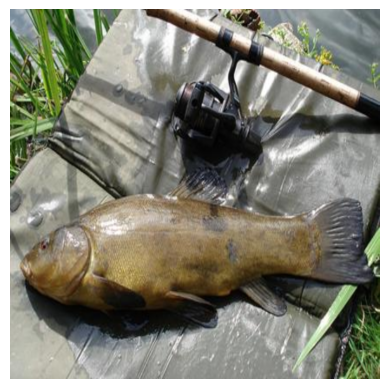

Output shape: (1, 3, 640, 640)


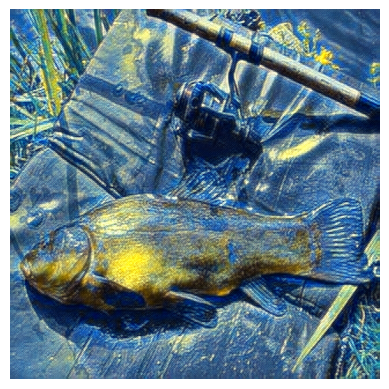

In [68]:
# check what the distilation model does
torch.cuda.empty_cache()
stylize_and_display_image(IMAGES_PATH / "val/n01440764/ILSVRC2012_val_00009111.JPEG", "/home/tomek/github/GBGST-optimisations/optimisation/transformerNetFusion_separated_4xscaled_distilled_fp16.onnx", dtype=np.float16)